In [1]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn import svm
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV

seed = 2023 # DO NOT CHANGE!

In [2]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")

sklearn version: 1.0.1
numpy version: 1.21.3
pandas version: 1.3.4
matplotlib version: 3.4.3
scanpy version: 1.9.1


# Load Data / Train-Test split
See model training notebooks for more information

In [3]:
BMMC = sp.read_h5ad("../GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
BMMC

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [4]:
from scipy.sparse import hstack, csc_matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

d = hstack((scaler.fit_transform(BMMC.X),scaler.fit_transform(BMMC.obsm['ATAC_gene_activity'])))
d = csc_matrix(d, dtype=np.float32)

In [5]:
data = d
data

<69249x148960 sparse matrix of type '<class 'numpy.float32'>'
	with 700391696 stored elements in Compressed Sparse Column format>

In [6]:
donors = np.unique(BMMC.obs['DonorID'])
test_donors_idx = [19593, 28045, 28483]
test_filter = np.isin(BMMC.obs['DonorID'], test_donors_idx)
train_filter = np.invert(test_filter)

n_train = np.sum(train_filter)
n_test = np.sum(test_filter)

X_test = data[test_filter]
X_train = data[train_filter]

Y_test = BMMC.obs['cell_type'][test_filter]
Y_train = BMMC.obs['cell_type'][train_filter]

train_donors = BMMC.obs[train_filter]['DonorID']

In [7]:
cell_types = np.unique(BMMC.obs['cell_type'])
main_cell_types = {
    'B Cells': ['B1 B', 'Naive CD20+ B', 'Transitional B', 'Plasma cell'],
    'T Cells': ['CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD8+ T naive'],
    'Monocytes/Macrophages': ['CD14+ Mono', 'CD16+ Mono'],
    'Myeloid Progenitors': ['G/M prog' , 'ID2-hi myeloid prog'],
    'Erythroid Cells': ['Erythroblast', 'Normoblast', 'Proerythroblast'],
    'Dendritic cells': ['cDC2', 'pDC']
}
main_cell_types_sorted = sorted(list(main_cell_types.keys()))

main_cell_types_mapping = {x:k for k,v in main_cell_types.items() for x in v}
missing_cell_types = list(set(cell_types) - set(main_cell_types_mapping.keys()))
missing_cell_types.sort()
print(f"No main cell type for: {missing_cell_types}")
for missing_cell_type in missing_cell_types:
    main_cell_types_mapping[missing_cell_type] = missing_cell_type
main_cell_types_mapping

main_cell_types_sorted = sorted(list(main_cell_types.keys()) + missing_cell_types)

to_main_cell_types = lambda x: np.vectorize(main_cell_types_mapping.get)(x)

cell_types_sorted = np.concatenate((np.array([x for k,v in main_cell_types.items() for x in v]), np.array(missing_cell_types)))
cell_types_sorted

No main cell type for: ['HSC', 'ILC', 'Lymph prog', 'MK/E prog', 'NK']


array(['B1 B', 'Naive CD20+ B', 'Transitional B', 'Plasma cell',
       'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD8+ T naive',
       'CD14+ Mono', 'CD16+ Mono', 'G/M prog', 'ID2-hi myeloid prog',
       'Erythroblast', 'Normoblast', 'Proerythroblast', 'cDC2', 'pDC',
       'HSC', 'ILC', 'Lymph prog', 'MK/E prog', 'NK'], dtype='<U19')

# Model Analysis

In [8]:
# load model
with open('../models/lsvm_normalized_multiome_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

In [9]:
test_pred = best_model.predict(X_test)
train_pred = best_model.predict(X_train)
all_pred = best_model.predict(data)

In [10]:
test_main_pred = to_main_cell_types(test_pred)
Y_test_main = to_main_cell_types(Y_test)
train_main_pred = to_main_cell_types(train_pred)
Y_train_main = to_main_cell_types(Y_train)

## Weights

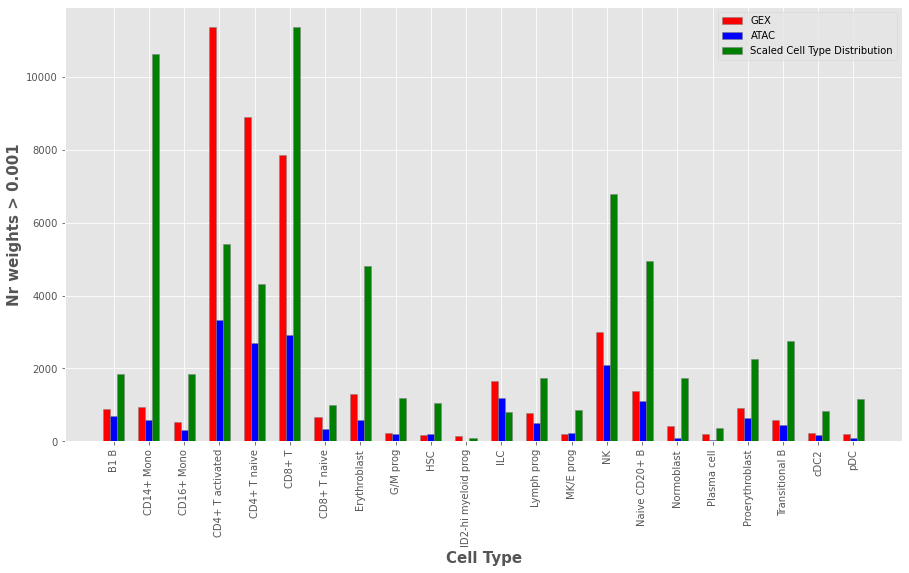

In [11]:
import matplotlib.pyplot as plt 
 
# set width of bar 
barWidth = 0.20
fig = plt.subplots(figsize=(15, 8))

# set heights of bars
n_gex_samples = BMMC.X.shape[1]
n_atac_samples = BMMC.obsm['ATAC_gene_activity'].shape[1]

weight_cutoff = 1e-3
idx = np.abs(best_model.coef_).argsort(axis=1)
n_sign_gex_w = [np.logical_and(best_model.coef_[i,id] >= weight_cutoff, id < n_gex_samples).sum() for i, id in enumerate(idx)]
n_sign_atac_w = [np.logical_and(best_model.coef_[i,id] >= weight_cutoff, id >= n_gex_samples).sum() for i, id in enumerate(idx)]

# scale
#n_sign_gex_w = n_sign_gex_w / n_gex_samples
#n_sign_atac_w = n_sign_atac_w / n_atac_samples

cell_types, cell_type_distr = np.unique(BMMC.obs['cell_type'], return_counts=True)
cell_type_distr = cell_type_distr / cell_type_distr.max() * max(list(n_sign_gex_w) + list(n_sign_atac_w))
 
# Set position of bar on X axis 
br1 = np.arange(len(cell_types)) 
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, n_sign_gex_w, color ='r', width = barWidth, 
        edgecolor ='grey', label ='GEX') 
plt.bar(br2, n_sign_atac_w, color ='b', width = barWidth, 
        edgecolor ='grey', label ='ATAC')
plt.bar(br3, cell_type_distr, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Scaled Cell Type Distribution') 

# Adding Xticks 
plt.xlabel('Cell Type', fontweight ='bold', fontsize = 15) 
plt.ylabel(f'Nr weights > {weight_cutoff}', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r, _ in enumerate(cell_types)], cell_types, rotation=90)

plt.legend(loc='upper right')
plt.show() 

## Accuracy

In [12]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

print("==== With Subtypes ====")
print(f"Train accuracy: {accuracy_score(Y_train, train_pred):.5f}")
print(f"Test accuracy: {accuracy_score(Y_test, test_pred):.5f}")
print("")
print(f"Balanced Train Accuracy: {balanced_accuracy_score(Y_train, train_pred):.5f}")
print(f"Balanced Test Accuracy: {balanced_accuracy_score(Y_test, test_pred):.5f}")
print("")
print("==== Main celltypes ====")
print(f"Train accuracy: {accuracy_score(Y_train_main, train_main_pred):.5f}")
print(f"Test accuracy: {accuracy_score(Y_test_main, test_main_pred):.5f}")
print("")
print(f"Balanced Train Accuracy: {balanced_accuracy_score(Y_train_main, train_main_pred):.5f}")
print(f"Balanced Test Accuracy: {balanced_accuracy_score(Y_test_main, test_main_pred):.5f}")

==== With Subtypes ====
Train accuracy: 1.00000
Test accuracy: 0.83819

Balanced Train Accuracy: 1.00000
Balanced Test Accuracy: 0.74380

==== Main celltypes ====
Train accuracy: 1.00000
Test accuracy: 0.93499

Balanced Train Accuracy: 1.00000
Balanced Test Accuracy: 0.78038


## F1 Score

In [13]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, test_pred))

                  precision    recall  f1-score   support

            B1 B       0.99      0.63      0.77       508
      CD14+ Mono       0.87      0.99      0.92      2269
      CD16+ Mono       0.96      0.88      0.92       370
CD4+ T activated       0.77      0.49      0.60      1167
    CD4+ T naive       0.30      0.67      0.41       463
          CD8+ T       0.93      0.95      0.94      5009
    CD8+ T naive       0.05      0.02      0.03       366
    Erythroblast       0.91      0.94      0.92       741
        G/M prog       0.81      0.22      0.35       617
             HSC       0.63      0.93      0.75       437
             ILC       0.96      0.18      0.30       129
      Lymph prog       0.94      0.74      0.83       573
       MK/E prog       0.72      0.71      0.71       293
              NK       0.89      0.95      0.92      1092
   Naive CD20+ B       0.79      0.99      0.88      1322
      Normoblast       0.97      0.96      0.97       237
     Plasma c

In [14]:
print(classification_report(Y_test_main, test_main_pred))

                       precision    recall  f1-score   support

              B Cells       0.95      0.99      0.97      2876
      Dendritic cells       0.95      0.94      0.94       759
      Erythroid Cells       0.98      0.95      0.96      1916
                  HSC       0.63      0.93      0.75       437
                  ILC       0.96      0.18      0.30       129
           Lymph prog       0.94      0.74      0.83       573
            MK/E prog       0.72      0.71      0.71       293
Monocytes/Macrophages       0.90      0.99      0.94      2639
  Myeloid Progenitors       0.81      0.22      0.35       617
                   NK       0.89      0.95      0.92      1092
              T Cells       0.98      0.99      0.98      7005

             accuracy                           0.93     18336
            macro avg       0.88      0.78      0.79     18336
         weighted avg       0.94      0.93      0.93     18336



## Confusion Matrices

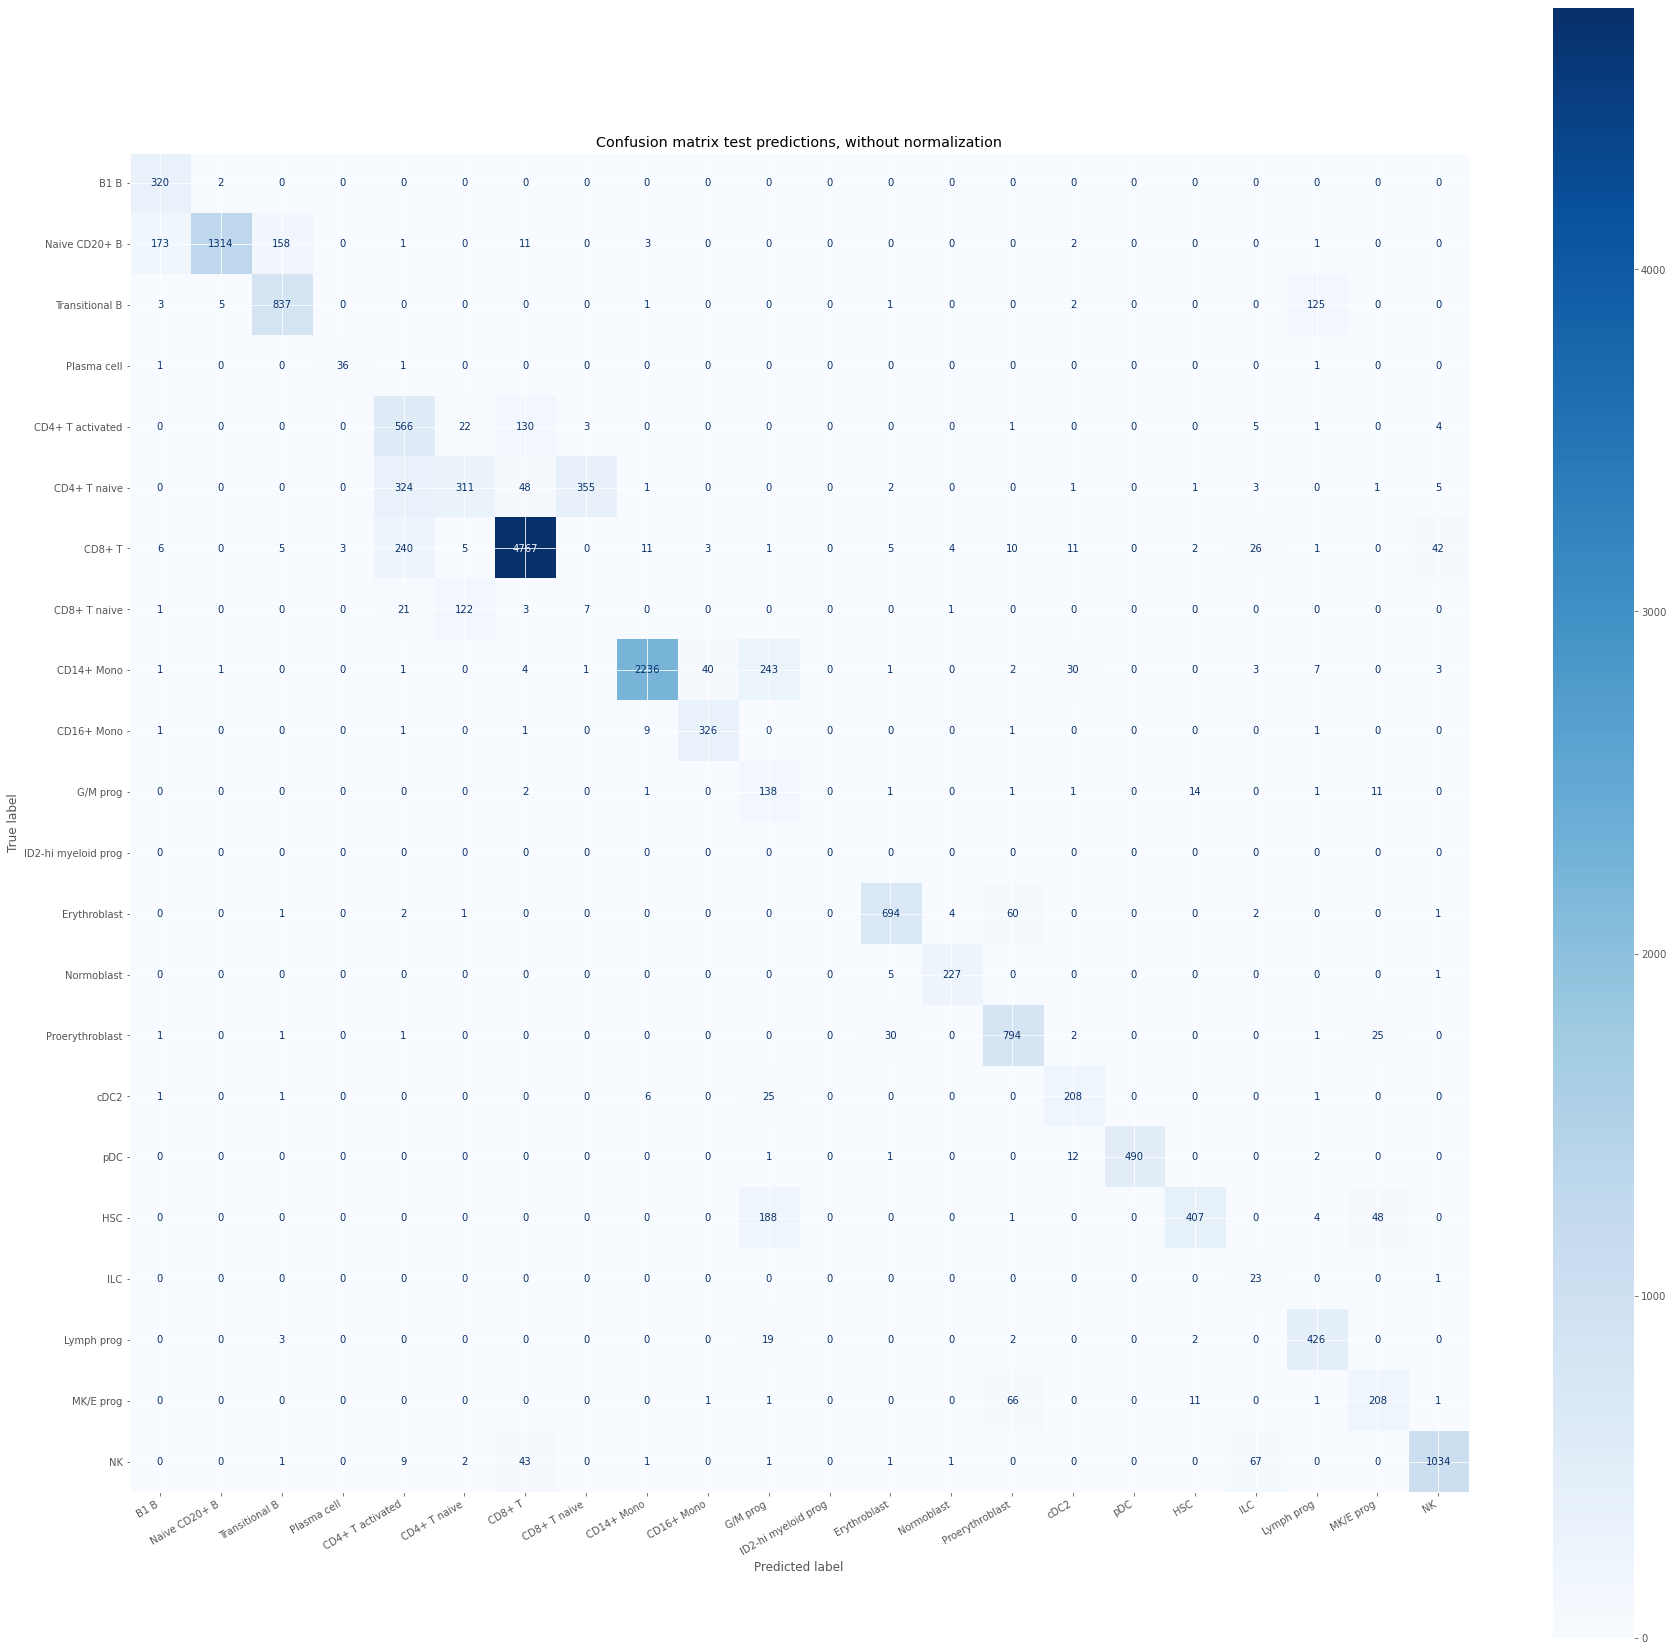

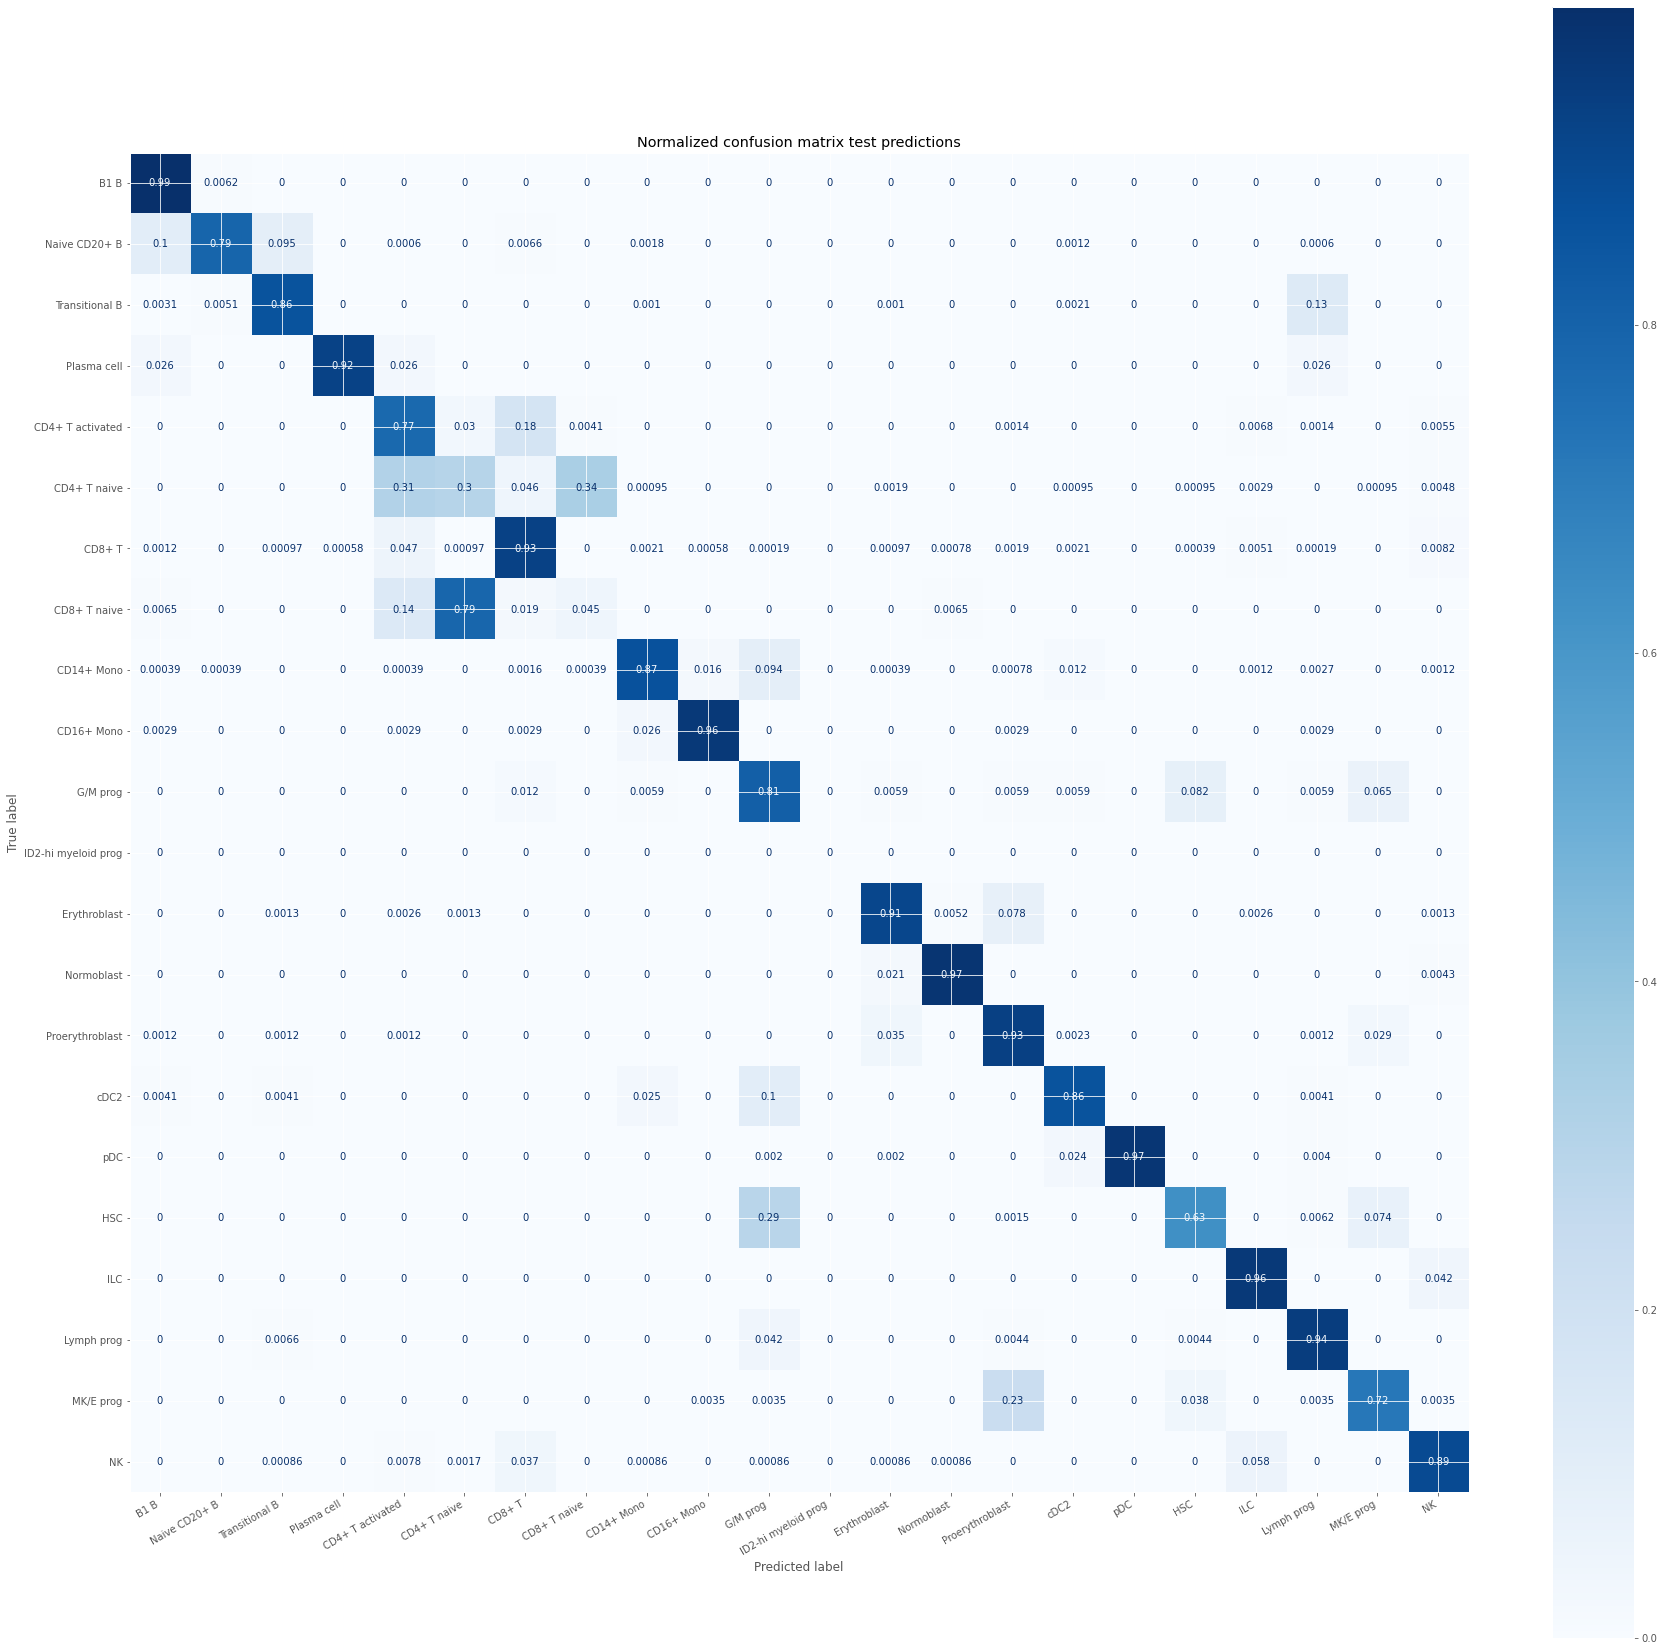

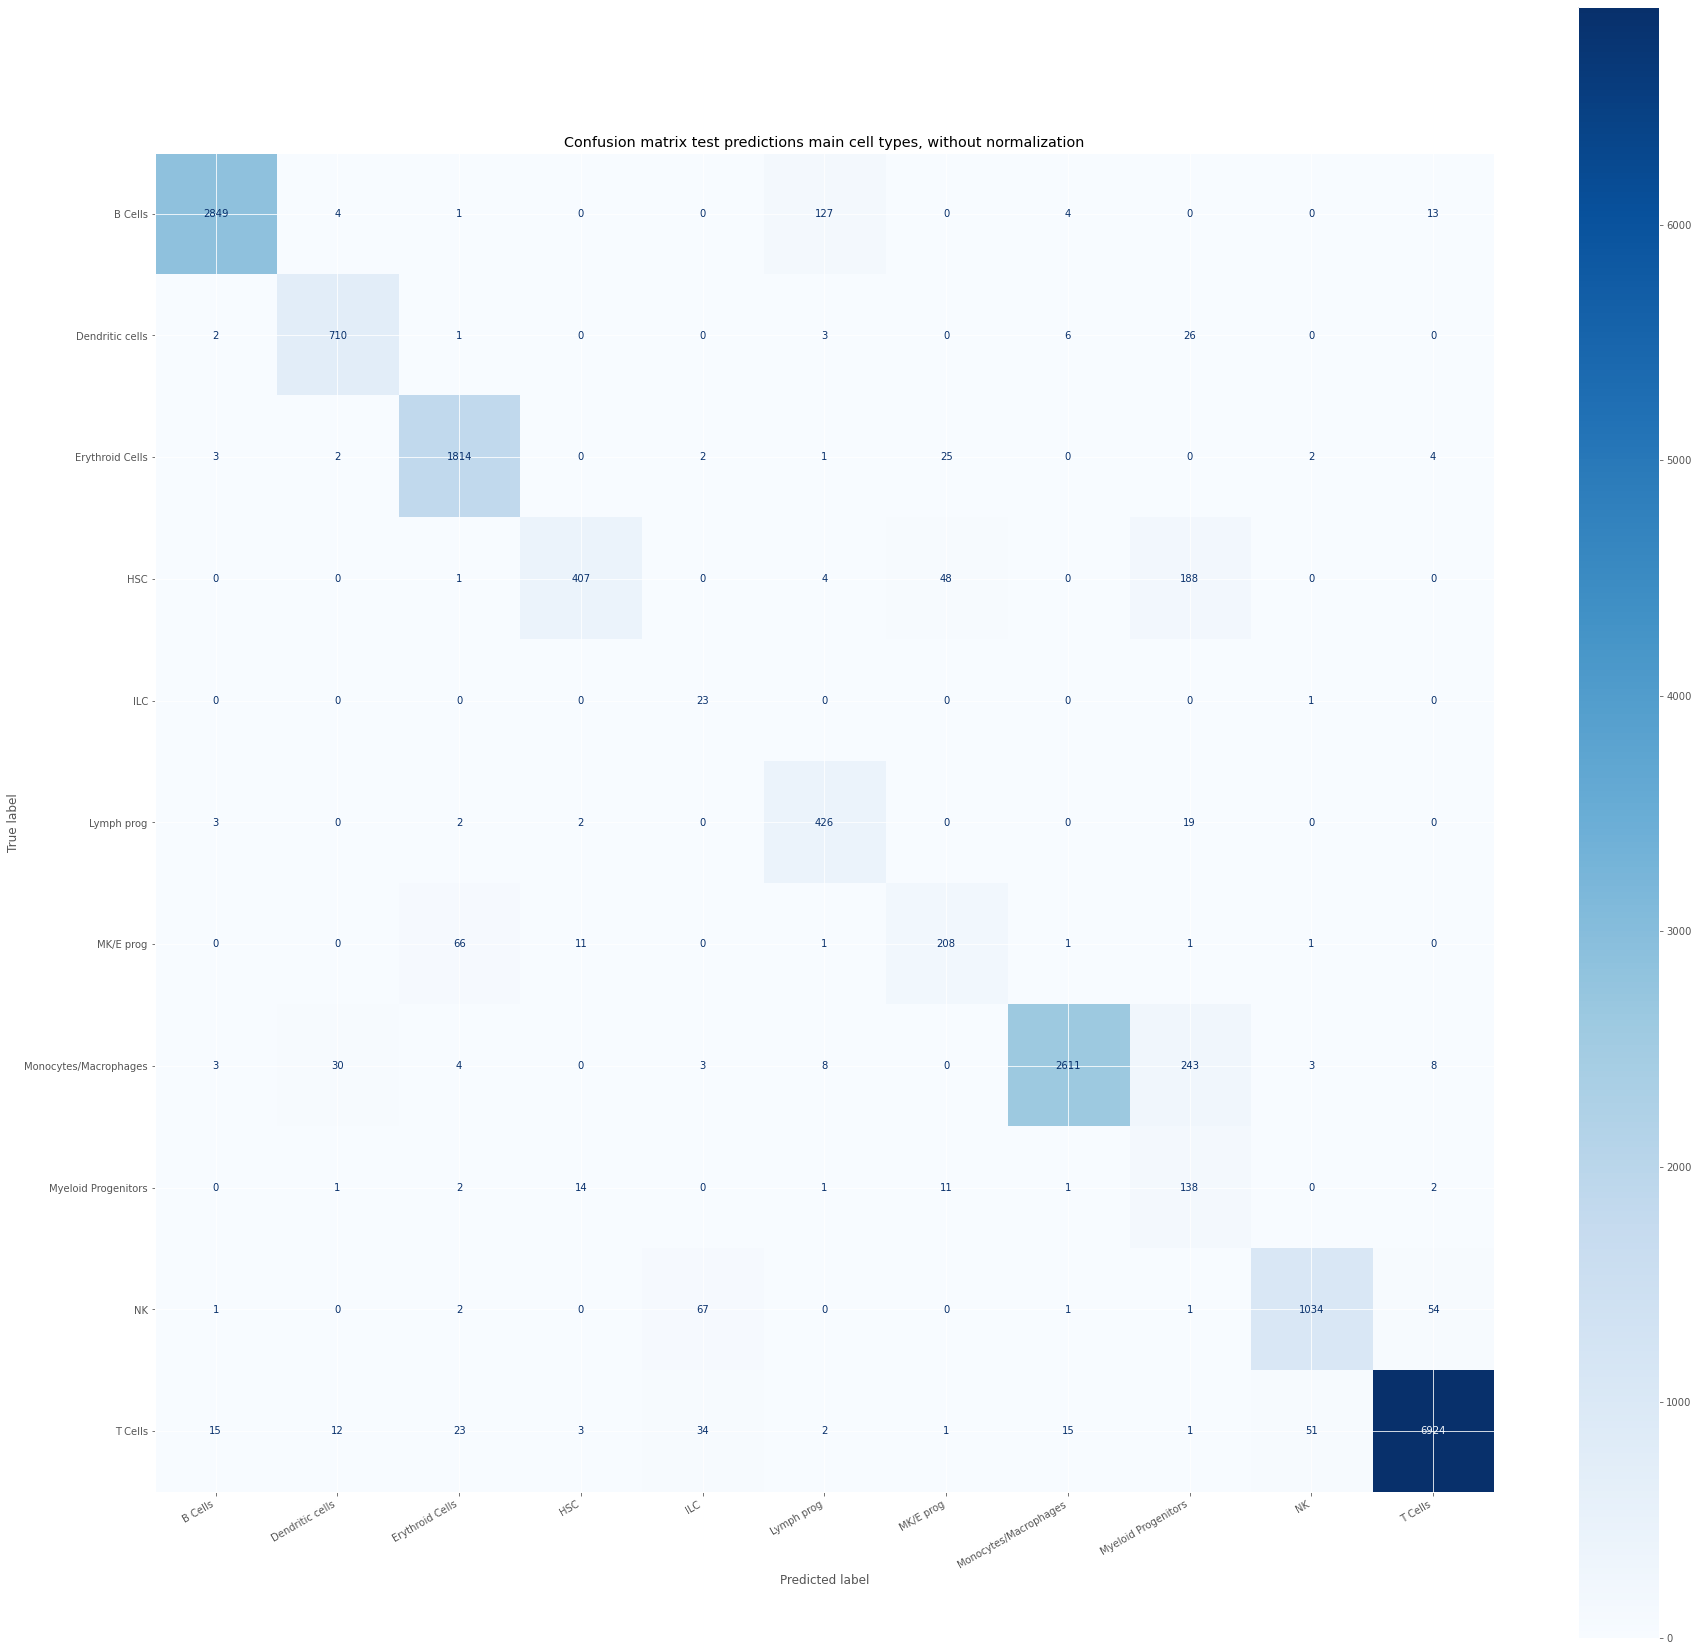

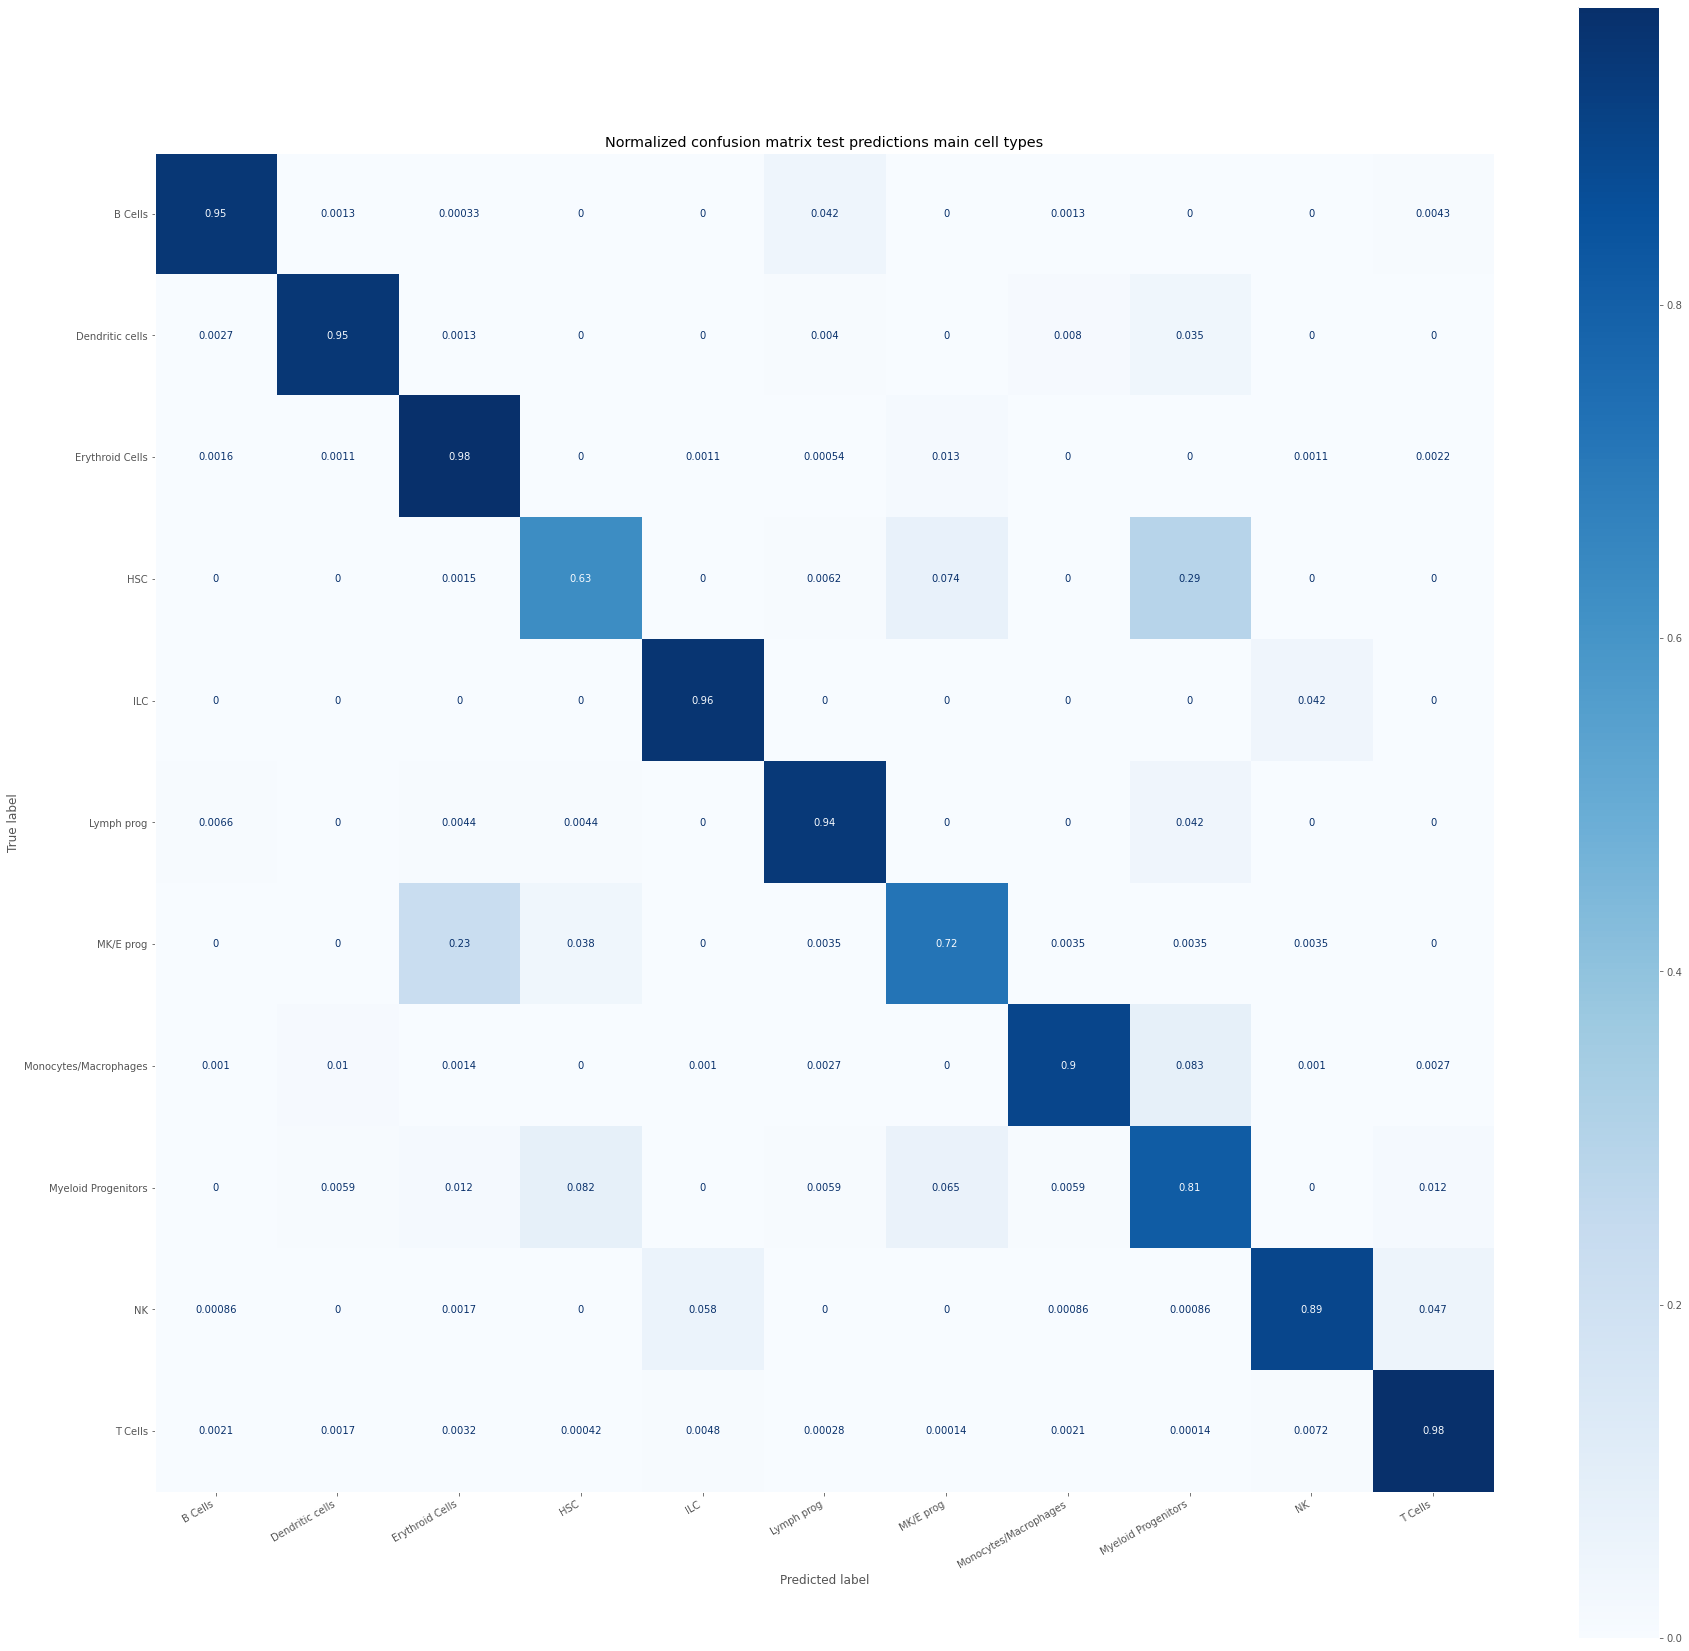

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix test predictions, without normalization", None, test_pred, Y_test, cell_types_sorted),
    ("Normalized confusion matrix test predictions", "true", test_pred, Y_test, cell_types_sorted),
    ("Confusion matrix test predictions main cell types, without normalization", None, test_main_pred, Y_test_main, main_cell_types_sorted),
    ("Normalized confusion matrix test predictions main cell types", "true", test_main_pred, Y_test_main, main_cell_types_sorted),
]
plt.rcParams['figure.figsize'] = [30, 30]
for title, normalize, pred, labels, celltypes in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        pred,
        labels,
        cmap=plt.cm.Blues,
        normalize=normalize,
        labels=celltypes
    )
    plt.xticks(rotation=30, ha='right')
    disp.ax_.set_title(title)

plt.grid(False)
plt.show()

## Umaps

In [16]:
umap_coordinates_train = BMMC.obsm['ATAC_umap'][train_filter]
umap_coordinates_test = BMMC.obsm['ATAC_umap'][test_filter]

def show_umap(_celltypes, _umapcoords, labels, title='UMAP Plot observations', s=10):
    colors = plt.cm.get_cmap('viridis', len(_celltypes))

    for i, ct_ in enumerate(_celltypes):
        mask = (labels == ct_)
        plt.scatter(_umapcoords[mask, 0], _umapcoords[mask, 1], label=ct_, color=colors(i), s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(title)
    plt.legend(title='Cell Type')
    return plt.show()

def show_predictions_umap(_umapcoords, _predictions, _labels, _celltypes, _maincelltypes=False, title='UMAP Plot prediction accuracy', s=10):
    RightPred_mask = (_predictions == _labels)
    plt.scatter(_umapcoords[RightPred_mask, 0], _umapcoords[RightPred_mask, 1], label="Right Prediction", color='green', s=s)
    
    if _maincelltypes:
        MainCellTypePred_mask = np.logical_and((to_main_cell_types(_predictions) == to_main_cell_types(_labels)), np.invert(RightPred_mask))
        plt.scatter(_umapcoords[MainCellTypePred_mask, 0], _umapcoords[MainCellTypePred_mask, 1], label="Right Main Cell Type Prediction", color='blue', s=s)
    
    WrongPred_Mask = np.invert(np.logical_or(RightPred_mask, MainCellTypePred_mask) if _maincelltypes else RightPred_mask)
    plt.scatter(_umapcoords[WrongPred_Mask, 0], _umapcoords[WrongPred_Mask, 1], label="Wrong Prediction", color='red', s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(title, fontsize=30)
    l = plt.legend(title='Cell Type', fontsize=30, title_fontsize=40)
    for legendHandle in l.legendHandles:
        legendHandle._sizes = [300]
    plt.show()

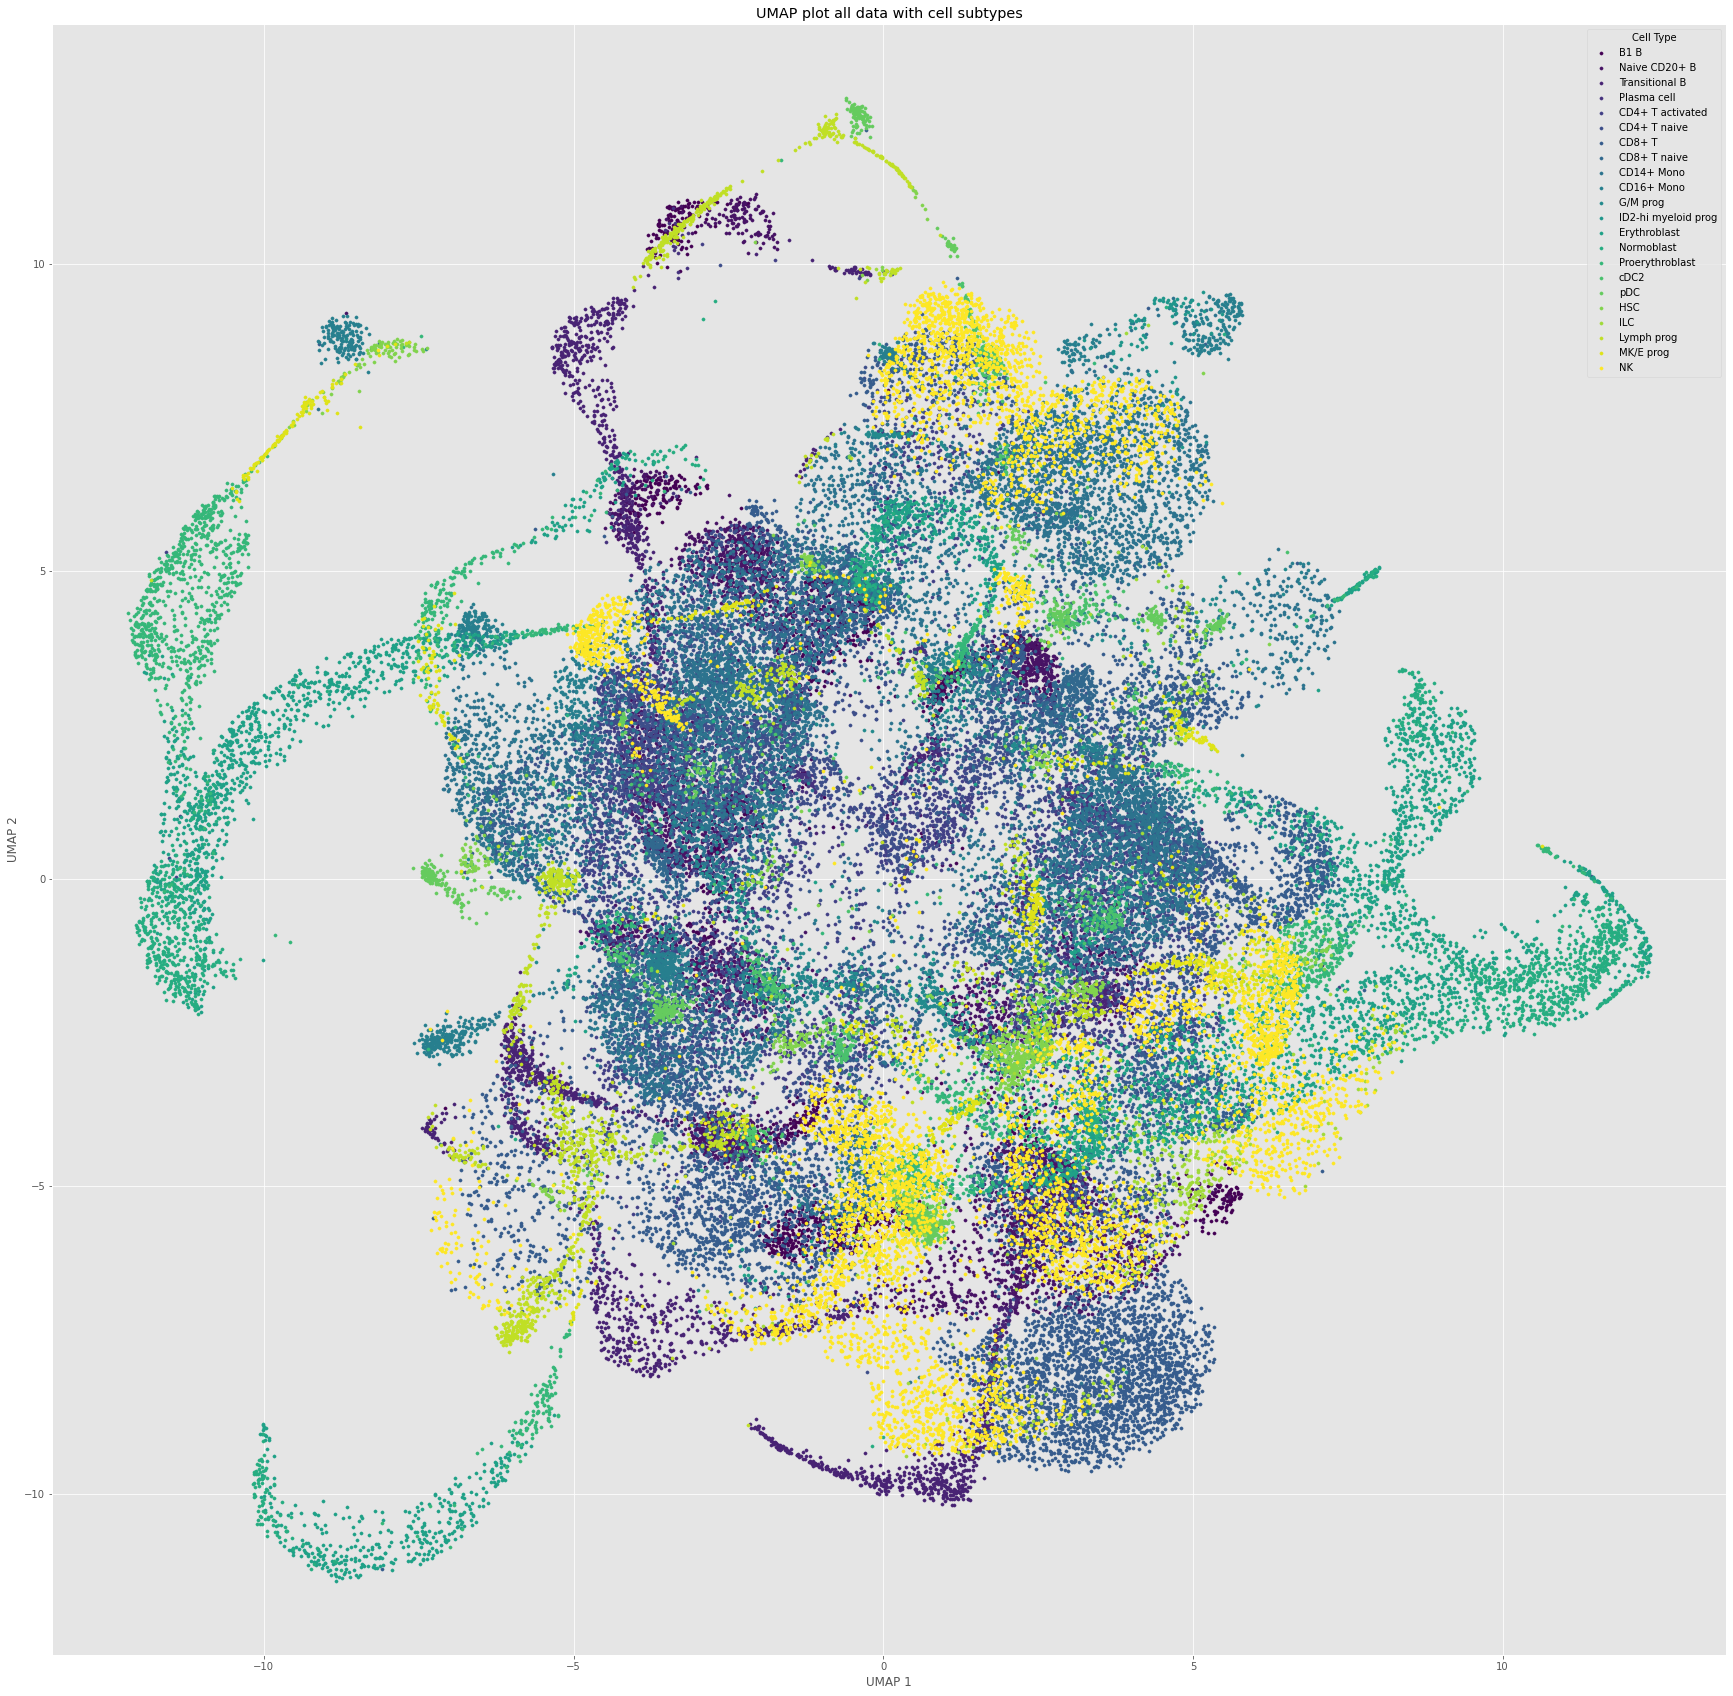

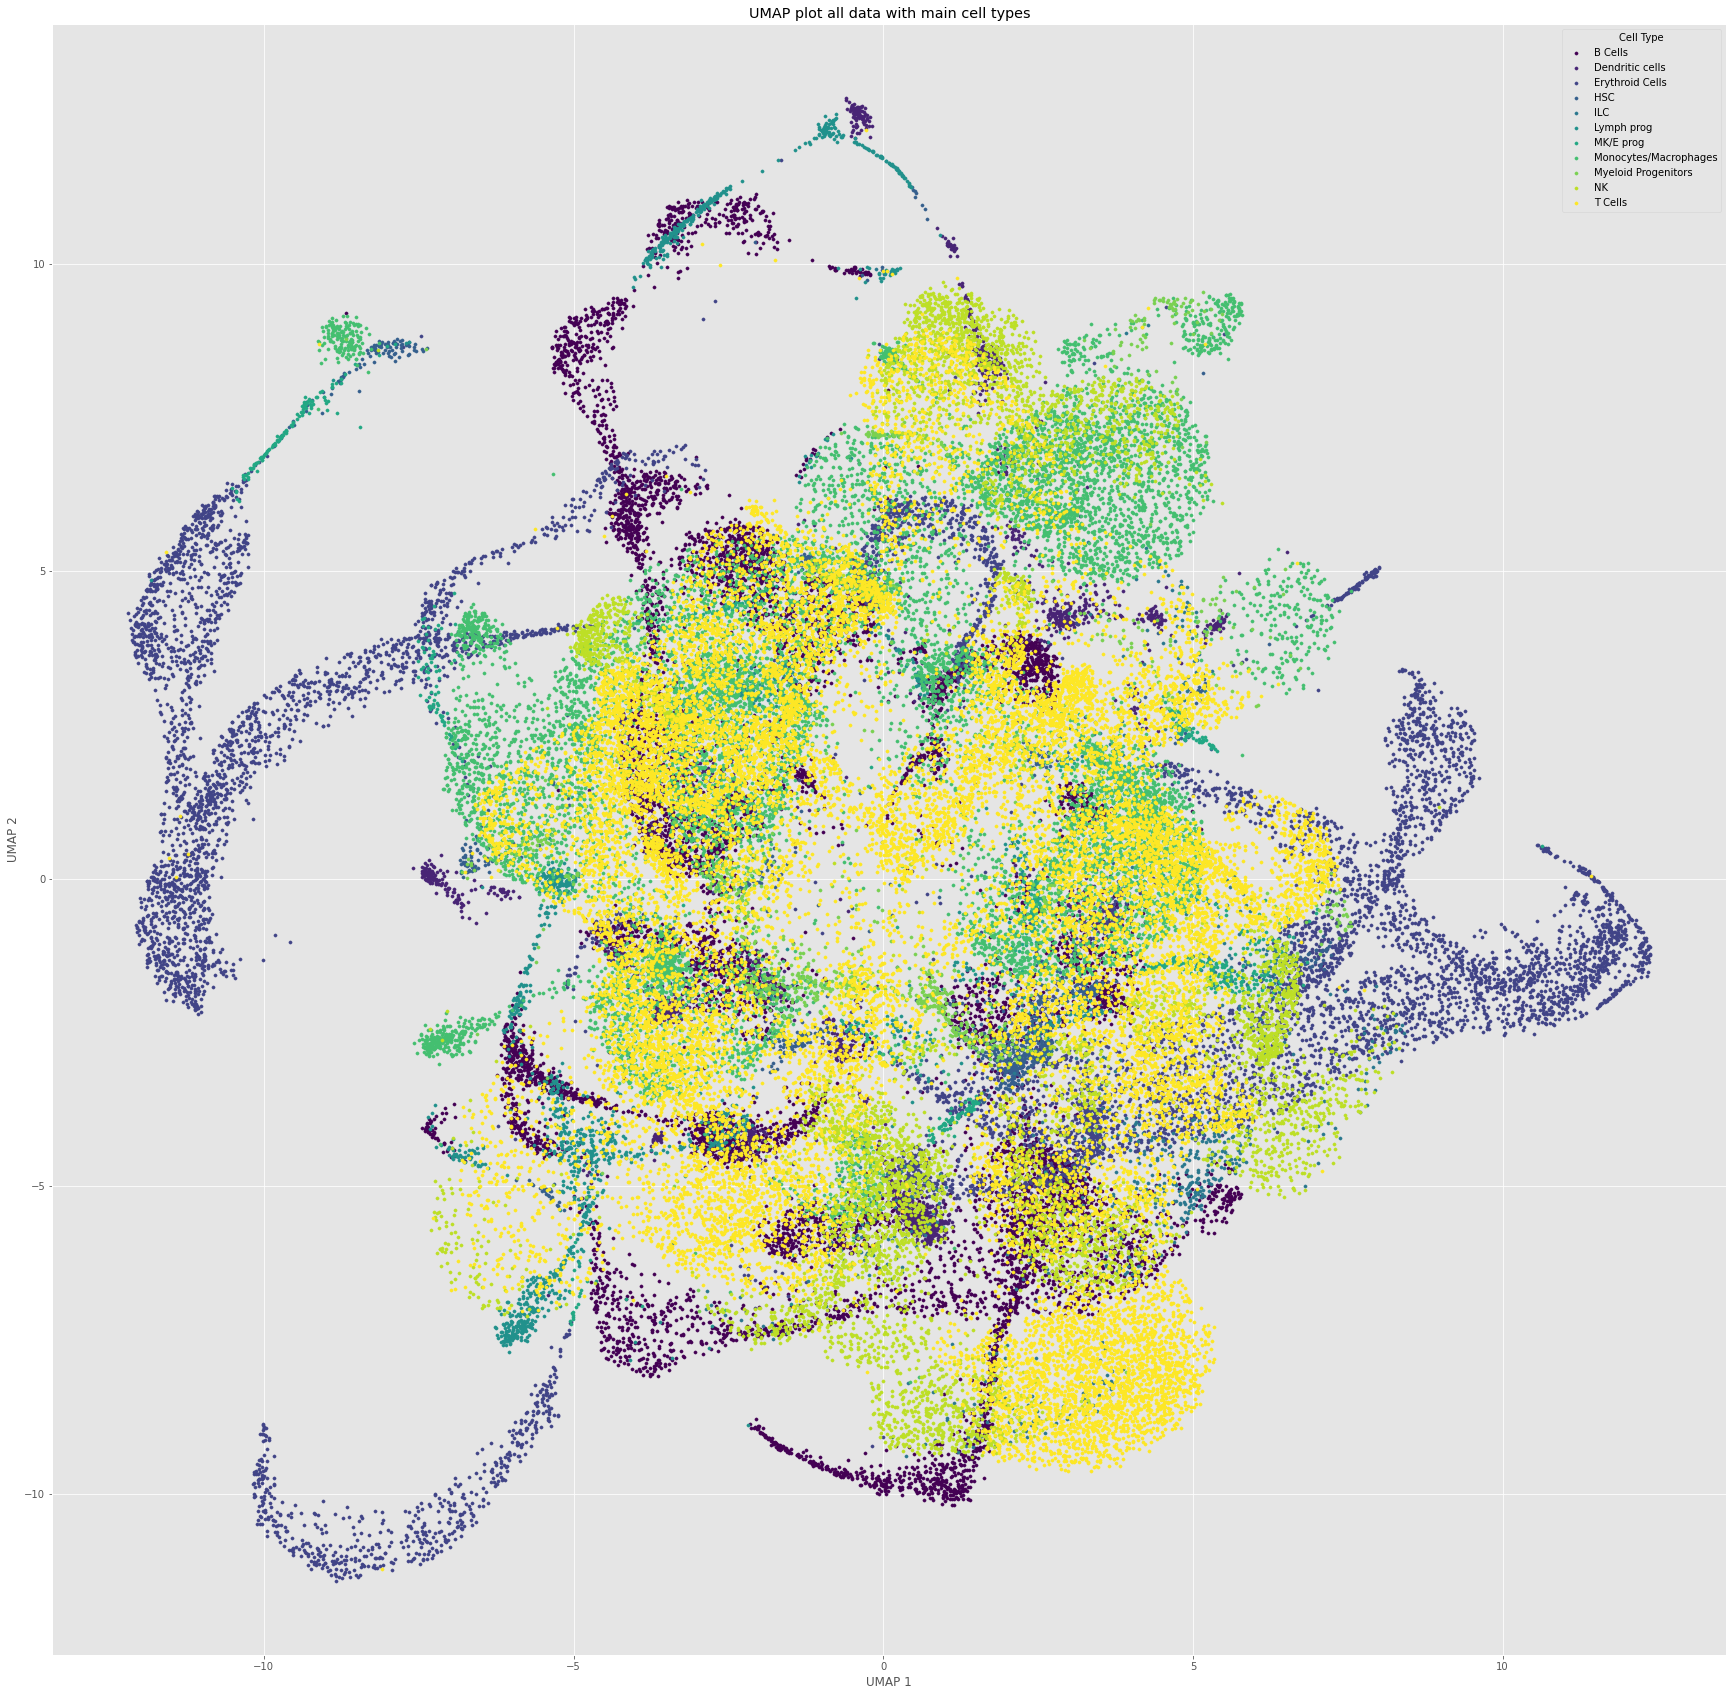

In [17]:
show_umap(cell_types_sorted, BMMC.obsm['ATAC_umap'], BMMC.obs['cell_type'], title="UMAP plot all data with cell subtypes")
show_umap(main_cell_types_sorted, BMMC.obsm['ATAC_umap'], to_main_cell_types(BMMC.obs['cell_type']), title="UMAP plot all data with main cell types")

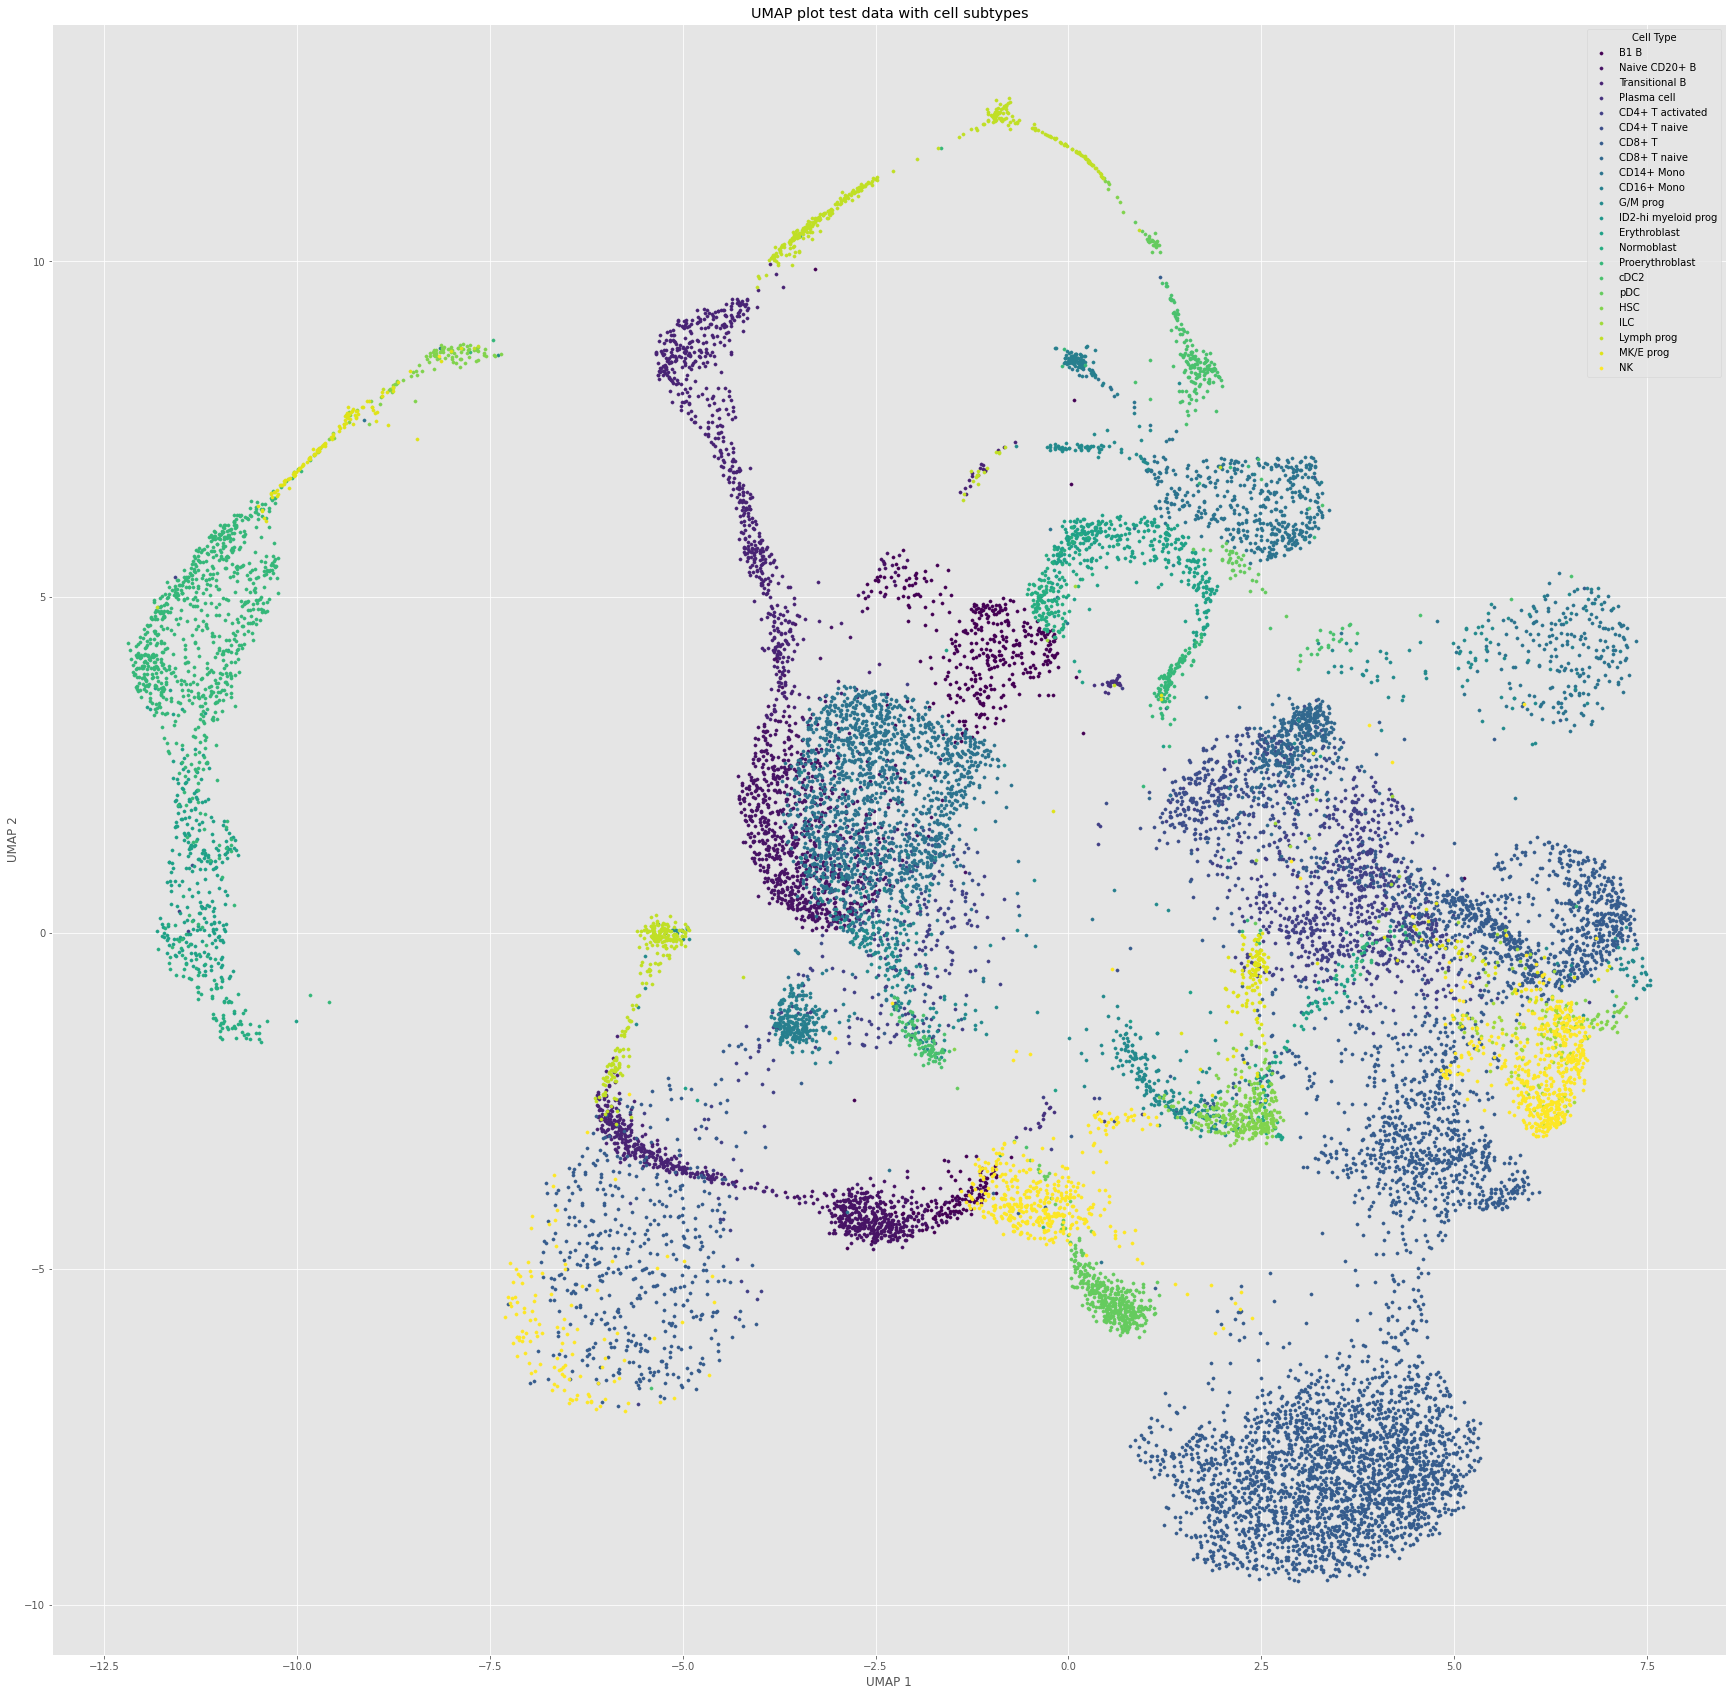

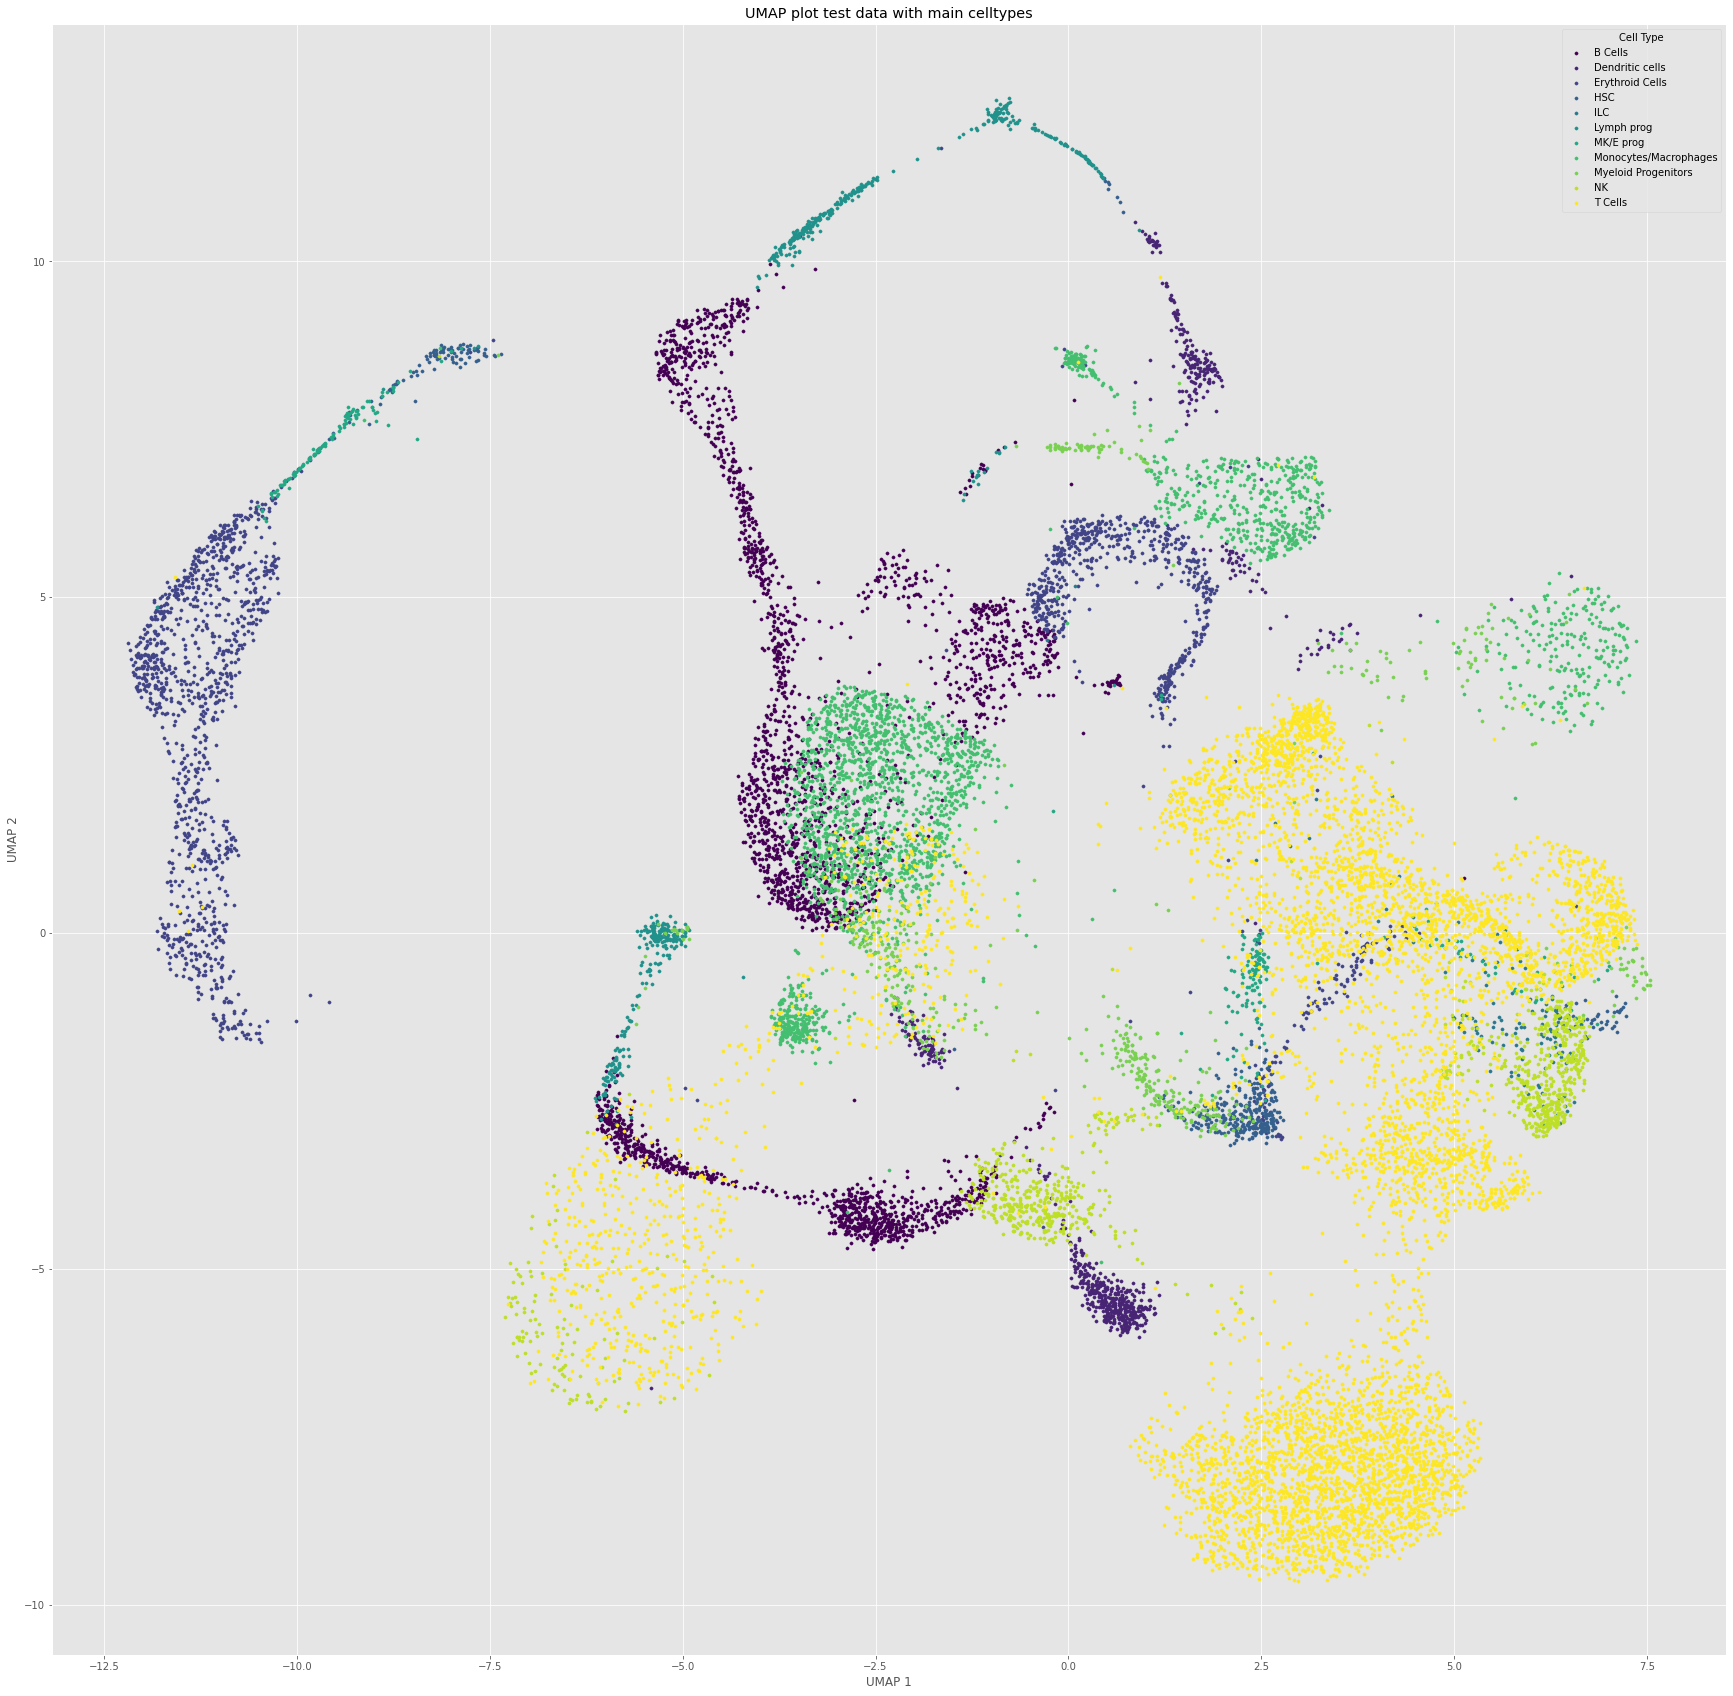

In [18]:
show_umap(cell_types_sorted, umap_coordinates_test, Y_test, title="UMAP plot test data with cell subtypes")
show_umap(main_cell_types_sorted, umap_coordinates_test, Y_test_main, title="UMAP plot test data with main celltypes")

In [ ]:
show_predictions_umap(umap_coordinates_test, test_pred, Y_test, cell_types_sorted, _maincelltypes=False, title='UMAP Plot prediction accuracy with subtypes', s=10)
show_predictions_umap(umap_coordinates_test, test_pred, Y_test, cell_types_sorted, _maincelltypes=True, title='UMAP Plot prediction accuracy with main celltypes', s=10)

In [ ]:
for d in donors:
    _dfilter = BMMC.obs['DonorID'] == d
    show_predictions_umap(BMMC.obsm['ATAC_umap'][_dfilter], all_pred[_dfilter], BMMC.obs['cell_type'][_dfilter], cell_types_sorted, _maincelltypes=True, title=f'UMAP Plot prediction accuracy {"test" if d in test_donors_idx else "train"} donor {d}', s=15)